In [1]:
%pylab inline --no-import-all
import math
import george
import numpy as np
import scipy.optimize as so
import scipy.stats as ss
import scipy.special as ssp
import time
from iminuit import Minuit
import ROOT as r
import matplotlib.ticker as ticker
import matplotlib.cm as cmap
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt
from george.kernels import ExpSquaredKernel

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


### Load the data histogram: Saved as arrays in InitialFits

In [68]:
ycounts = np.load("inputs/ycounts.npy")
yerrs = np.load("inputs/yerrs.npy")
xbins = np.load("inputs/xbins.npy")
xerrs = np.load("inputs/xerrs.npy")
toyData = np.load("inputs/toys.npy")
xlow = list(xbins-xerrs/2.)
fixedHyperparameters = np.load("inputs/fixedHyperparameters.npy")

standardParamSets = [(1500,2000,250), (750 ,2500, 250),(500, 3000, 250), (200, 3500, 250), (100, 4000, 250), 
             (75, 4500, 250), (50, 5000, 250), (30,5500, 250), (25, 6000,250)]

### Useful functions

#### Gausian function to use as a signal

In [14]:
def sig_model(x, N=1e5, mass=2000., width=100.):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*np.append(np.diff(x),np.diff(x)[-1])

#### Calculate the z-val and chi squared fit between data and fit. The signficance is plotted in the bottom panel of makePrettyPlots

In [15]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

#### Poisson likelihood

In [16]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

#### Non central chi squared to fit to log likelihood ratio 

In [17]:
def ncchi(x, nc):
    return ss.ncx2.pdf(x, 1., nc) 

#### Distribution of log likelihood ratio. Can draw on a chi squared when looking at the ratio with no signal added (since we expect the distribution of our test statistic with one additional signal parameter to follow a chi squared), or you can fit for a non central chi squared when there is a signal added.

In [18]:
def makePrettyPlots_LLH(GP_LLH, title, drawchi2=False, drawNCchi2=False, xname=r'$\chi^{2}$'):
    f, (ax1) = plt.subplots(1, figsize=(10,5))
    f.suptitle(title, fontsize=20)

    lowx = 0
    highx = max(GP_LLH)+1
    
    bins = np.linspace(lowx, highx, 100)
    dx = bins[1]-bins[0]
    bin_centers = bins[:-1] + dx/2.
    hGP, _, _ = ax1.hist(GP_LLH, bins=bins, color="b")
    #print hGP
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    #ax1.set_title(label, fontsize=20)
    ax1.set_xlabel(xname, fontsize=20)
    if drawchi2:
        chi2_gp = sum(hGP)*(bins[1]-bins[0])*ss.chi2.pdf(bin_centers, 1.)
        ax1.plot(bin_centers, chi2_gp, c='r', linewidth=2)
    if drawNCchi2:
        best_fit_params, _ = so.curve_fit(ncchi, bin_centers, hGP)
        print "nc ", best_fit_params
        nc_chi = sum(hGP)*dx*ss.ncx2.pdf(bin_centers, 1., best_fit_params[0]) 
        ax1.plot(bin_centers, nc_chi, c='r', linewidth=3)
    
    plt.show()

#### Plot signal+background fit, background only component and data together. Show significance of signal+background to signal+data, background to signal+data, and background to data

In [41]:
def makePrettyPlots_sb(x, y_sd, y_d, bkg, bkg_s, xlow, title, ymax = 2e7):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(x, y_sd, marker='o', ls='None', yerr = np.sqrt(y_sd), c='black', markersize=10, label="data+signal")
    bkgPlot_b, = ax1.plot(x, bkg, color='g', linewidth=3.0, label="bkg only")
    bkgPlot_sb, = ax1.plot(x, bkg_s, color='b', linewidth=3.0, label="bkg+signal")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.3, ymax])
    ax1.tick_params(axis='y', labelsize=20)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(y_sd, bkg_s)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    #print h1[:]
    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("data+sig vs bkg+sig",(1020,3.5), fontsize=15)
    #ax2.set_ylim([-2, 8])

    zvals_2, chi2_2 = calcSignificance(y_sd, bkg)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'blue'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("data+signal vs bkg",(1020,3.5), fontsize=15)
    
    zvals_3, chi2_3 = calcSignificance(y_d, bkg)
    print "chi2 bkg+signal", chi2_3
    h3 = Hist(xlow,markersize=0)
    for x in range(len(zvals_3)):
        if zvals_3[x] == np.inf or zvals_3[x] == -np.inf: h3[x] = 20
        else: h3[x] = zvals_3[x]  
    h3.fillstyle = 'solid'
    h3.fillcolor = 'red'
    h3.linecolor = 'black'
    h3.linewidth = 1
    h3.Draw("histX0")
    rplt.bar(h3, xerr=None, yerr=None, axes=ax4)
    ax4.axhline(0, color='black', lw=1)
    ax4.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax4.set_ylabel('Significance', fontsize=15)
    ax4.set_xscale('log')
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    ax4.set_ylim([-5, 5])
    ax4.set_xlim([1000, 7500])
    ax4.annotate("data vs bkg",(1020,3.5), fontsize=15)

    ax4.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax4.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax4.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

In [42]:
def makePrettyPlots_signal(x, y_d, bkg, bkg_s, xlow, title, ymax = 2e7):
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(x, y_d, marker='o', ls='None', yerr = np.sqrt(y_d), c='black', markersize=10, label="data+signal")
    bkgPlot_b, = ax1.plot(x, bkg, color='g', linewidth=3.0, label="bkg only")
    bkgPlot_sb, = ax1.plot(x, bkg_s, color='b', linewidth=3.0, label="bkg+signal")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.3, ymax])
    ax1.tick_params(axis='y', labelsize=20)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(y_d, bkg)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    #print h1[:]
    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    #ax2.set_ylim([-2, 8])
    ax2.annotate("data vs bkg",(1020,3.5), fontsize=15)

    zvals_2, chi2_2 = calcSignificance(y_d, bkg_s)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'blue'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax3.set_ylabel('Significance', fontsize=20)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("data vs bkg+sig",(1020,3.5), fontsize=15)

    ax3.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax3.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax3.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### Mean of the Gaussian Process - 3 parameter dijet fit function

In [54]:
from george.modeling import ModelingMixin
class Mean(ModelingMixin):
    def get_value(self, t):
        sqrts = 13000.
        return (self.p0 * (1.-t/sqrts)**self.p1 * (t/sqrts)**(self.p2))*np.append(np.diff(t), np.diff(t)[-1])

### Log likelihood with a signal strength term added. The likelihood is a built in Gaussian likelihood in george. Then call minuit to minimize the likelihood. Minuit is only fitting for the signal strength parameter - all other hyperparameters (mean and kernel) are kept fixed from the initial GP fit to data

In [57]:
class logLike_minuit:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, length, p0, p1, p2):
        kernel = Amp*ExpSquaredKernel(length)
        gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp.compute(self.x, np.sqrt(self.y))
        return -gp.lnlikelihood(self.y)

        
def fit_gp_minuit(num, lnprob):
    min_likelihood = np.inf
    best_fit_params = (0, 0, 0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 100.
        init1 = np.random.random() * 20.
        init2 = np.random.random() * 1. 
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Amp = init0, length = init1, 
                   p0 = init2, p1 = init3, p2 = init4,
                   error_Amp = 1e1, error_length = 1e1,
                   error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (0.1, 1e10), limit_length = (100, 1e5), 
                   limit_p0 = (0,10), limit_p1 = (-20, 20), limit_p2 = (-20,20)) 
        m.migrad()
        if m.fval < min_likelihood:
            min_likelihood = m.fval
            best_fit_params = m.args 
    print "min LL", min_likelihood
    print "best fit vals", best_fit_params
    return min_likelihood, best_fit_params

In [58]:
lnProb = logLike_minuit(xbins, toyData[10], xerrs)
min_likelihood, best_fit_gp = fit_gp_minuit(100, lnProb)
Amp, length, p0, p1, p2 = best_fit_gp
print best_fit_gp

min LL 346.474534421
best fit vals (0.37782665057151943, 99999.99999982533, 0.03470664232622156, 7.8788201235579365, -5.259441688330288)
(0.37782665057151943, 99999.99999982533, 0.03470664232622156, 7.8788201235579365, -5.259441688330288)


In [59]:
best_fit_hyp=best_fit_gp

In [60]:
class logLike_gp:
    def __init__(self, x, y, sigTemp):
        self.x = x
        self.y = y
        self.sigTemp = sigTemp
    def __call__(self, N):
        Amp, length, p0, p1, p2 = best_fit_hyp
        kernel = Amp*ExpSquaredKernel(length)
        gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y-N*self.sigTemp)
        except:
            return np.inf        
        
def fit_gp(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, 
                   N = init0, error_N = 1e-4, limit_N = (0, 100)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

(1500, 2000, 250)
0
background only time: 0.00363802909851
background only time: 0.00280594825745
SIGNAL STRENGTH NO SIGNAL 0.637735547947
background + signal time: 0.0752840042114
SIGNAL STRENGTH WITH SIGNAL 1.63776240796
chi2 bkg+signal mu=0 103.530891348
chi2 bkg+signal 148.984195606
chi2 bkg+signal 110.828742355


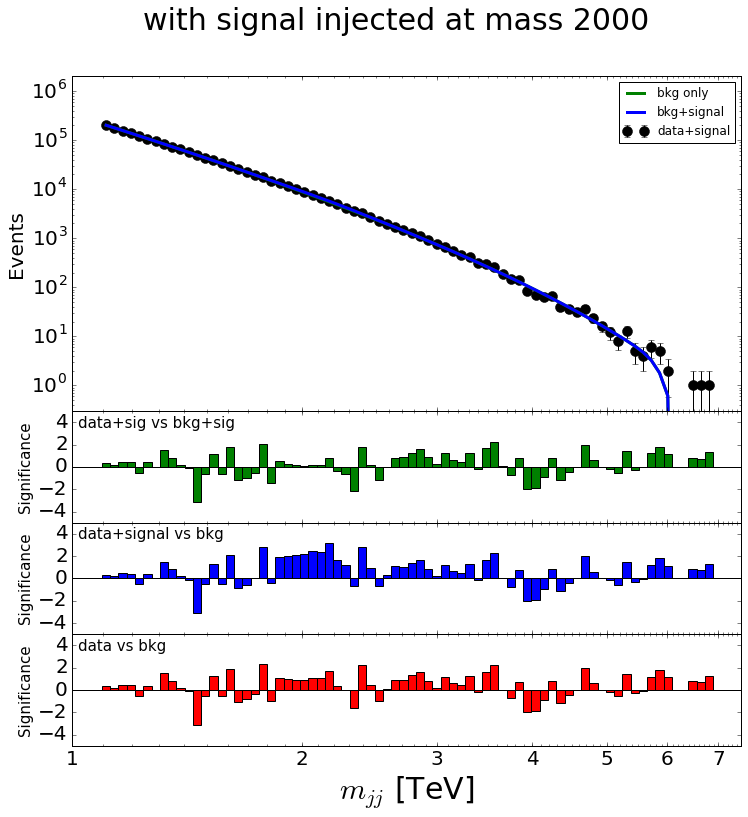

chi2 bkg+signal mu=0 110.847607059
chi2 bkg+signal 103.726373902


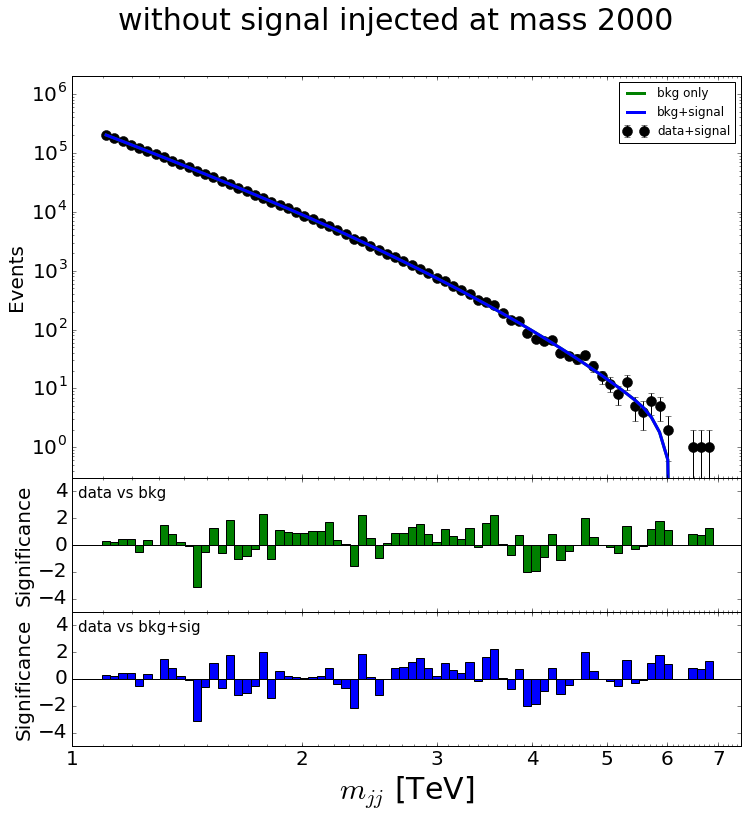

background + signal time: 6.86348390579
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(750, 2500, 250)
0
background only time: 0.00255703926086
background only time: 0.00236010551453
SIGNAL STRENGTH NO SIGNAL 0.535866987185
background + signal time: 0.0332050323486
SIGNAL STRENGTH WITH SIGNAL 1.53636082885
chi2 bkg+signal mu=0 104.689018582
chi2 bkg+signal 150.161787103
chi2 bkg+signal 110.786613273


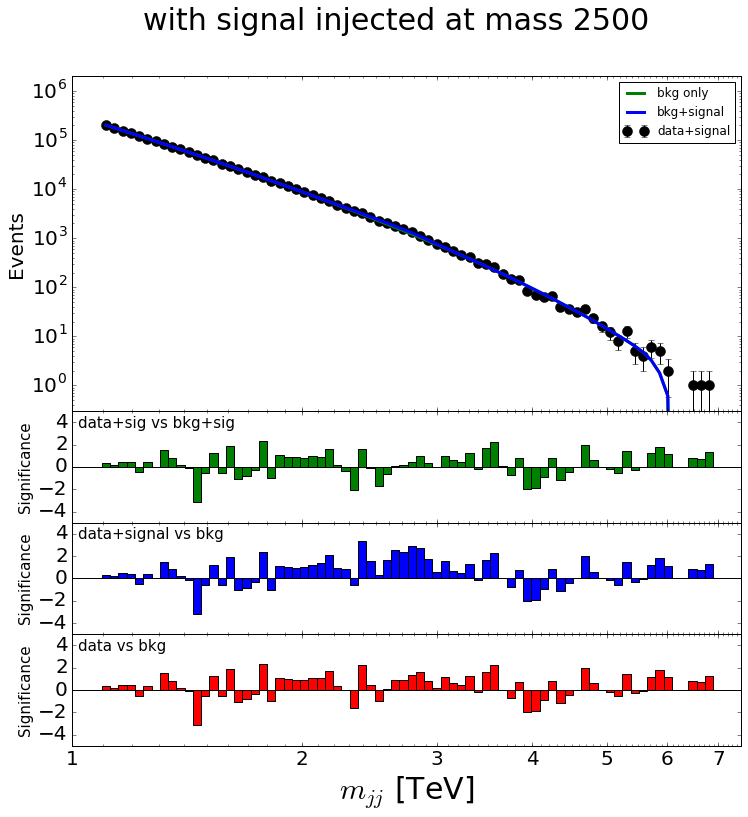

chi2 bkg+signal mu=0 110.847607059
chi2 bkg+signal 104.991182213


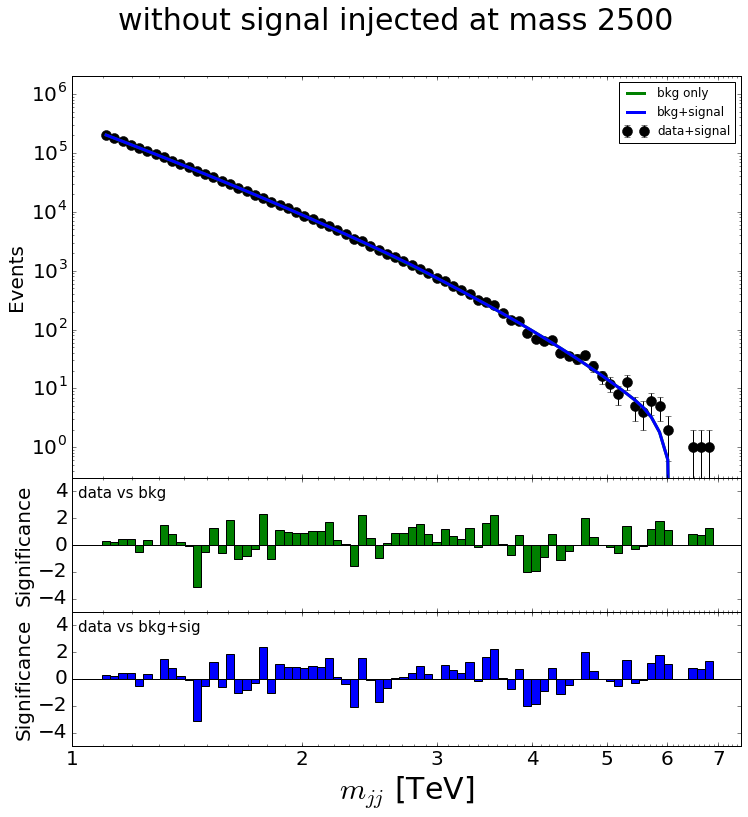

background + signal time: 6.48734116554
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(500, 3000, 250)
0
background only time: 0.00397086143494
background only time: 0.00355100631714
SIGNAL STRENGTH NO SIGNAL 0.4650384747
background + signal time: 0.0349049568176
SIGNAL STRENGTH WITH SIGNAL 1.47321393706
chi2 bkg+signal mu=0 102.310926551
chi2 bkg+signal 178.965146684
chi2 bkg+signal 110.676473879


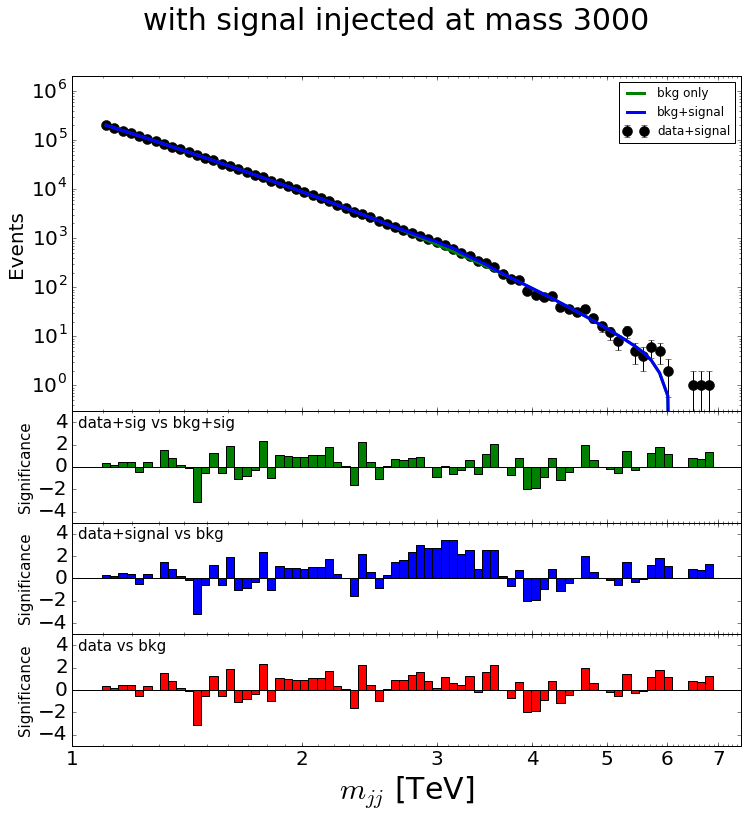

chi2 bkg+signal mu=0 110.847607059
chi2 bkg+signal 102.771088844


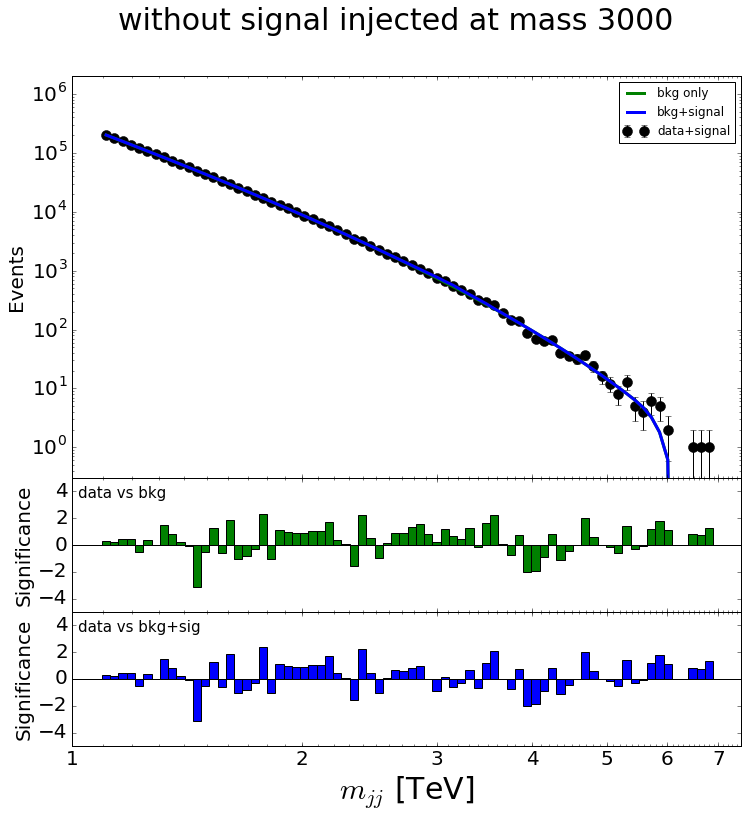

background + signal time: 8.65484905243
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(200, 3500, 250)
0
background only time: 0.00259113311768
background only time: 0.00244212150574
SIGNAL STRENGTH NO SIGNAL 0.222106419334
background + signal time: 0.0303781032562
SIGNAL STRENGTH WITH SIGNAL 1.23817465442
chi2 bkg+signal mu=0 107.923707333
chi2 bkg+signal 136.787820413
chi2 bkg+signal 110.815823113


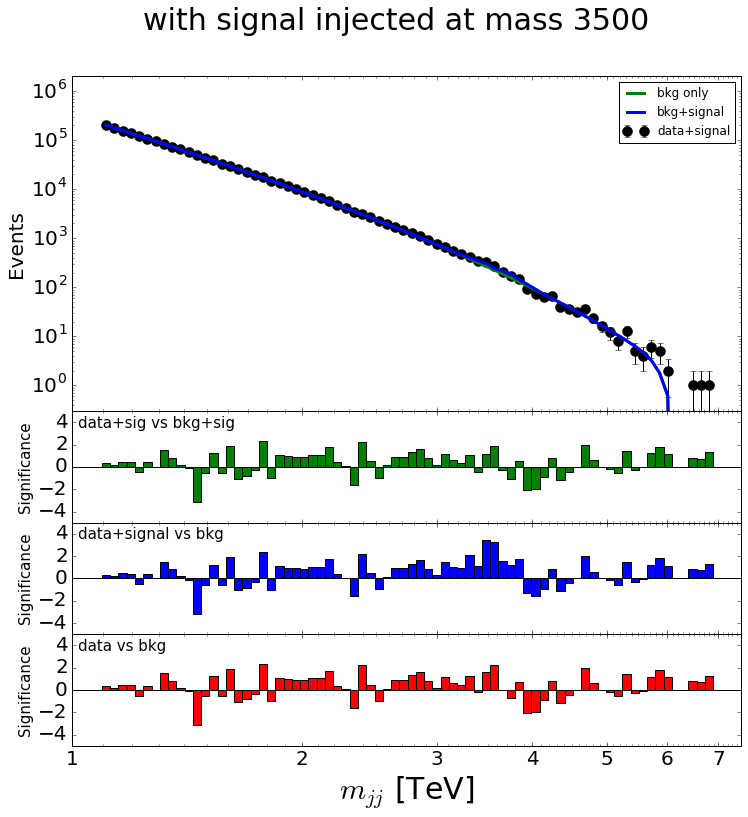

chi2 bkg+signal mu=0 110.847607059
chi2 bkg+signal 109.16108873


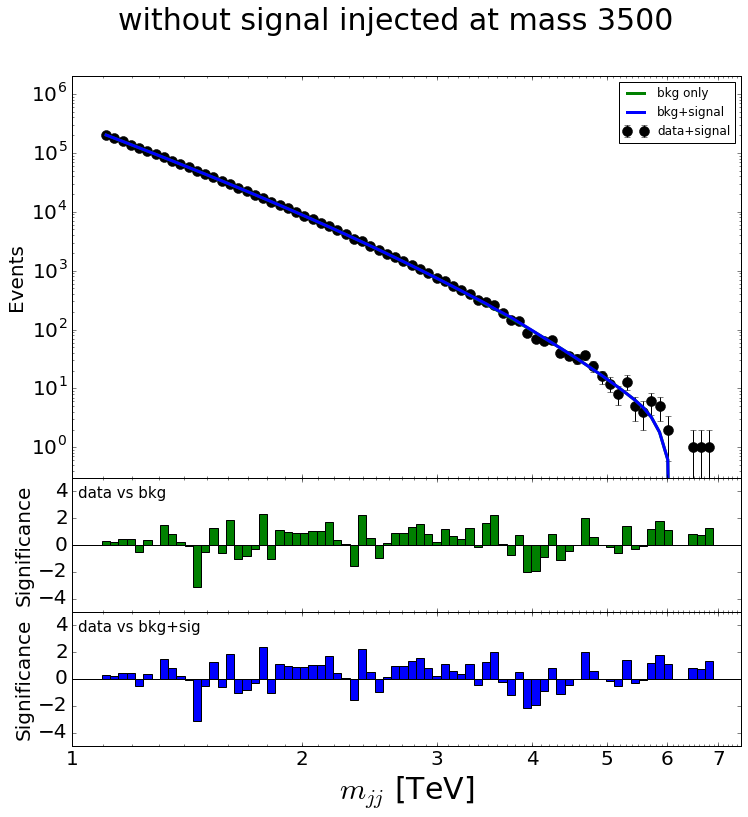

background + signal time: 6.58397388458
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(100, 4000, 250)
0
background only time: 0.00289392471313
background only time: 0.00223708152771
SIGNAL STRENGTH NO SIGNAL 5.1486592767e-10
background + signal time: 0.0339260101318
SIGNAL STRENGTH WITH SIGNAL 0.313222276401
chi2 bkg+signal mu=0 107.799687938
chi2 bkg+signal 109.675268463
chi2 bkg+signal 110.972823124


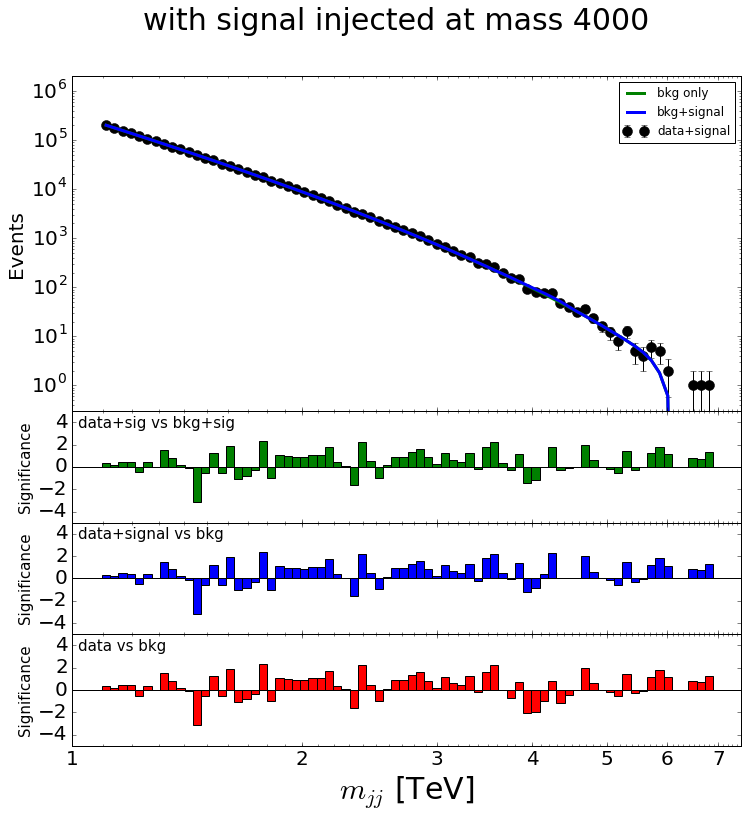

chi2 bkg+signal mu=0 110.847607059
chi2 bkg+signal 110.847607063


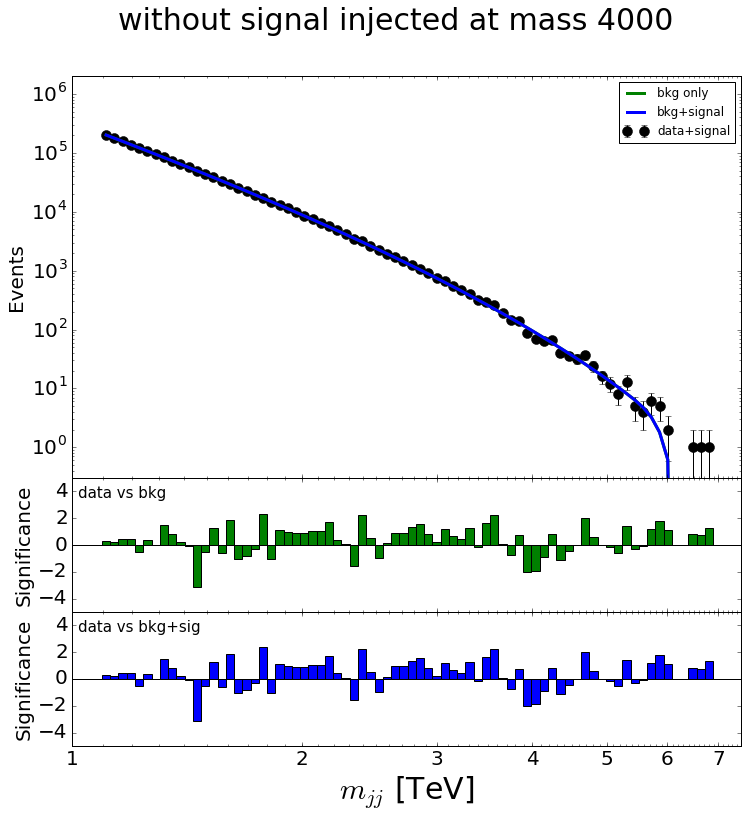

background + signal time: 6.72982597351
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(75, 4500, 250)
0
background only time: 0.00230979919434
background only time: 0.00197601318359
SIGNAL STRENGTH NO SIGNAL 3.92444521324e-07
background + signal time: 0.037672996521
SIGNAL STRENGTH WITH SIGNAL 0.897586827117
chi2 bkg+signal mu=0 109.206132754
chi2 bkg+signal 135.457816663
chi2 bkg+signal 110.695603813


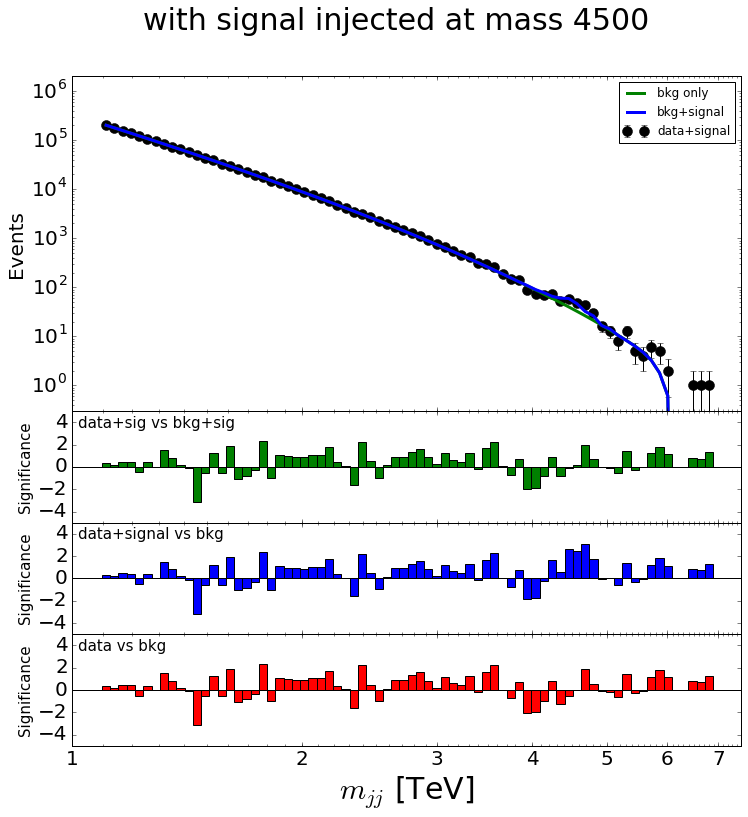

chi2 bkg+signal mu=0 110.847607059
chi2 bkg+signal 110.847607


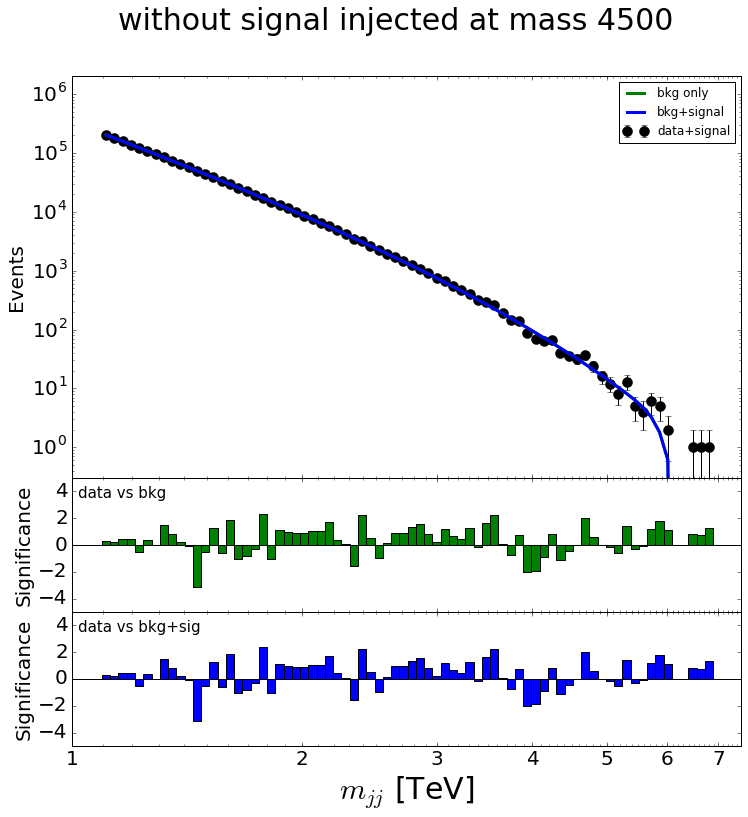

background + signal time: 6.51594996452
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(50, 5000, 250)
0
background only time: 0.00223112106323
background only time: 0.0021870136261
SIGNAL STRENGTH NO SIGNAL 0.111543184304
background + signal time: 0.0359539985657
SIGNAL STRENGTH WITH SIGNAL 1.15188249178
chi2 bkg+signal mu=0 107.283610223
chi2 bkg+signal 144.853243966
chi2 bkg+signal 109.761483157


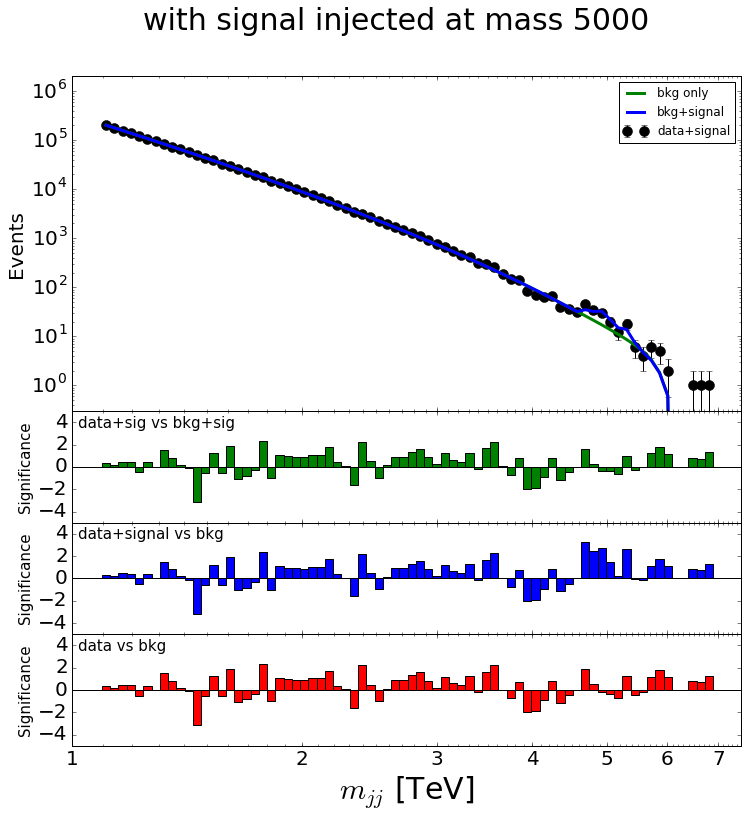

chi2 bkg+signal mu=0 110.847607059
chi2 bkg+signal 109.719793269


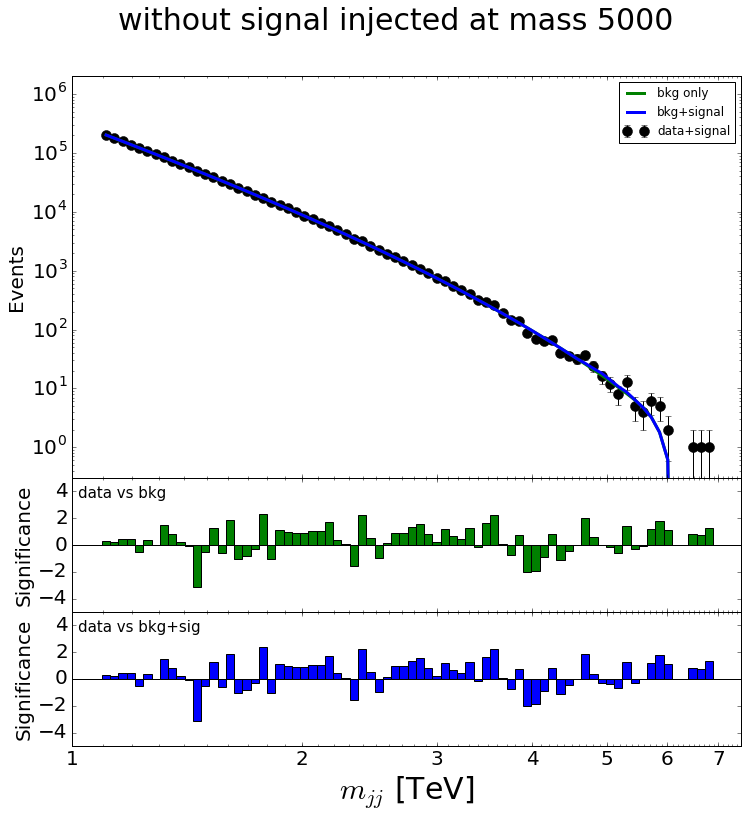

background + signal time: 6.51416897774
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(30, 5500, 250)
0
background only time: 0.00327706336975
background only time: 0.00284194946289
SIGNAL STRENGTH NO SIGNAL 0.199825679059
background + signal time: 0.0350270271301
SIGNAL STRENGTH WITH SIGNAL 1.23504487207
chi2 bkg+signal mu=0 101.48376762
chi2 bkg+signal 168.982921561
chi2 bkg+signal 105.905113482


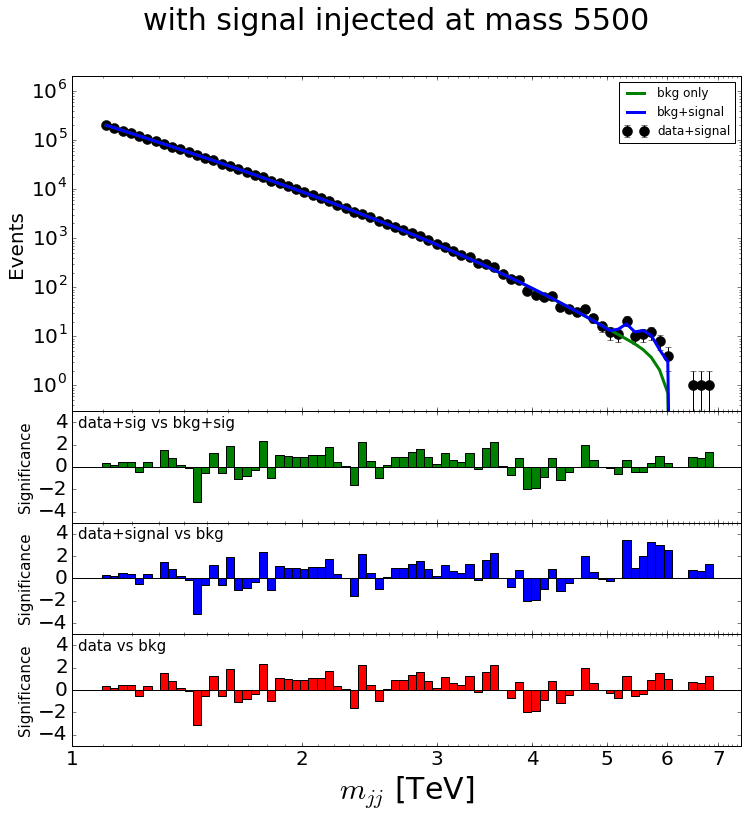

chi2 bkg+signal mu=0 110.847607059
chi2 bkg+signal 105.33460774


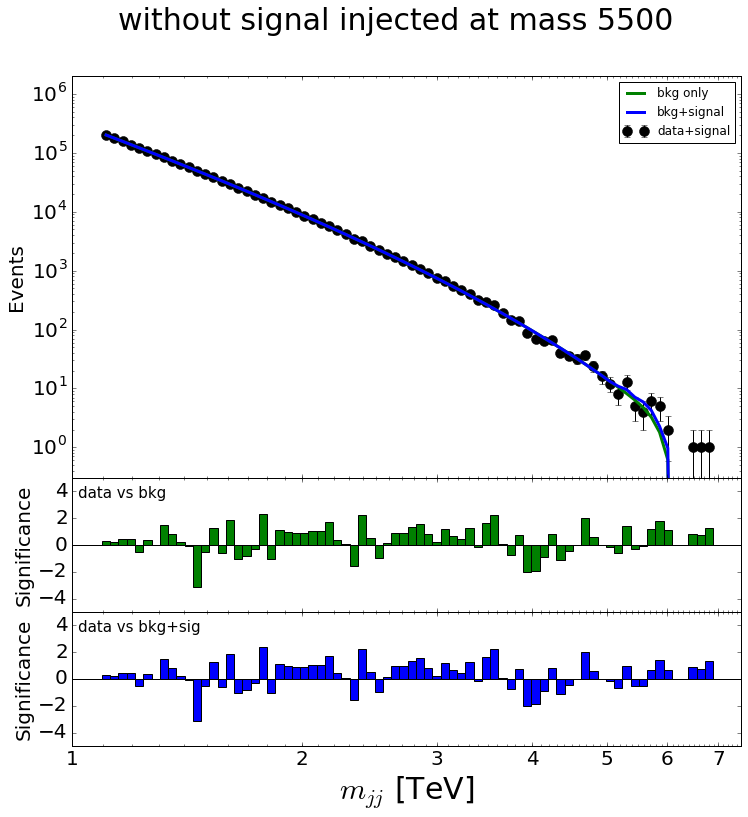

background + signal time: 6.48148703575
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(25, 6000, 250)
0
background only time: 0.00367021560669
background only time: 0.00267386436462
SIGNAL STRENGTH NO SIGNAL 1.62308111396e-08
background + signal time: 0.0314538478851
SIGNAL STRENGTH WITH SIGNAL 0.898338685691
chi2 bkg+signal mu=0 97.5943612147
chi2 bkg+signal 118.678135214
chi2 bkg+signal 98.8764794862


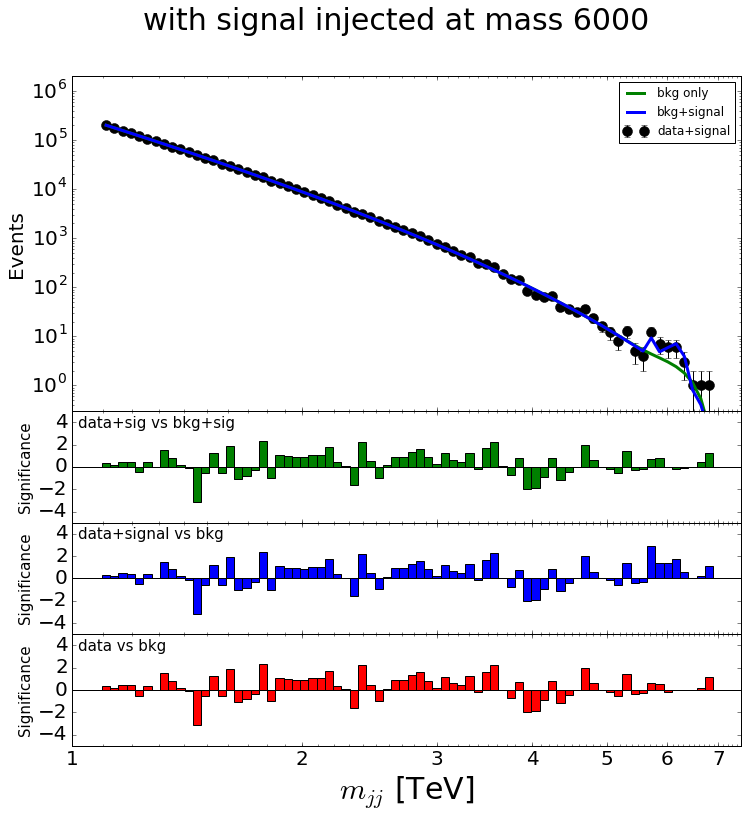

chi2 bkg+signal mu=0 110.847607059
chi2 bkg+signal 110.847607398


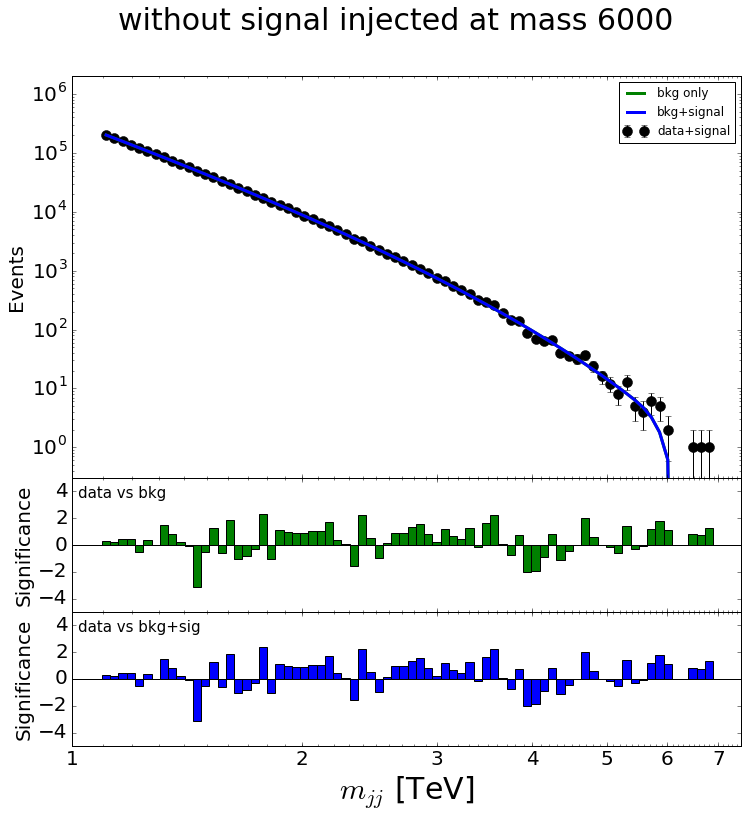

background + signal time: 6.41212487221
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
took 2.06095275111hours


In [69]:
btime=time.time()

LLHR_GP_noSignal={}
LLHR_GP_withSignal={}
for pSet in standardParamSets:
    n, m, w = pSet
    print pSet
    LLHR_GP_noSignal[m]=[]
    LLHR_GP_withSignal[m]=[]

    for itoy, toy in enumerate(toyData):
        if not itoy%100: 
            print itoy
        
        #for yi, y in enumerate(toy): 
        #    if y == 0: 
        #        print "hi", yi
        signalTemplate = np.random.poisson(np.round(sig_model(xbins, n, m, w)))
        dataPlusSignal = toy+signalTemplate
        Amp, length, p0, p1, p2 = best_fit_hyp #fixedHyperparameters
        kernel = Amp*ExpSquaredKernel(length)
        
        #############################################################################
        #BACKGROUND ONLY FIT TO DATA ONLY
        if itoy==0:
            pgpb_stime = time.time()
                
        gp_bkg = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp_bkg.compute(xbins, np.sqrt(toy))
        MAP_bkg, covGP_bkg = gp_bkg.predict(toy, xbins)
        LLH_bkg = gp_bkg.lnlikelihood(toy)
            
        if itoy==0:
            pgpb_etime = time.time()
            print "background only time:", pgpb_etime-pgpb_stime
        #############################################################################
        #BACKGROUND ONLY FIT TO DATA+SIGNAL ONLY
        if itoy==0:
            pgpb_stime = time.time()
                
        gp_bkg_sd = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp_bkg_sd.compute(xbins, np.sqrt(dataPlusSignal))
        MAP_bkg_sd, covGP_bkg_sd = gp_bkg_sd.predict(dataPlusSignal, xbins)
        LLH_bkg_sd = gp_bkg_sd.lnlikelihood(dataPlusSignal)
            
        if itoy==0:
            pgpb_etime = time.time()
            print "background only time:", pgpb_etime-pgpb_stime
        #############################################################################
        

        #############################################################################        
        #BACKGROUND+SIGNAL FIT GP
        if itoy==0:
            pgpsb_stime = time.time()

        lnProb = logLike_gp(xbins, toy, signalTemplate)
        minLLH, best_fit_gp = fit_gp(lnProb, False)
        if np.isinf(minLLH): continue
        signal_strength = best_fit_gp[0]

        gp_sigbkg = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp_sigbkg.compute(xbins, np.sqrt(toy))
        MAP, covGP = gp_sigbkg.predict(toy - signal_strength*signalTemplate, xbins)
        MAP_sigbkg = MAP+signal_strength*signalTemplate
        LLH_sigbkg = gp_sigbkg.lnlikelihood(toy - signal_strength*signalTemplate)

        if itoy==0:
            print "SIGNAL STRENGTH NO SIGNAL", signal_strength
            pgpsb_etime = time.time()
            print "background + signal time:", pgpsb_etime - pgpsb_stime
        
        LLHR_GP_noSignal[m].append(-2*(LLH_bkg-LLH_sigbkg))
        #############################################################################    
            
        #BACKGROUND+SIGNAL FIT GP ON DATA+SIGNAL
        if itoy==0:
            pgpsb_sd_stime = time.time()

        lnProb = logLike_gp(xbins, dataPlusSignal, signalTemplate)
        minLLH, best_fit_gp = fit_gp(lnProb, False)
        if np.isinf(minLLH): continue
        signal_strength_sd = best_fit_gp[0]

        gp_sigbkg_sd = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp_sigbkg_sd.compute(xbins, np.sqrt(dataPlusSignal))
        MAP, covGP = gp_sigbkg_sd.predict(dataPlusSignal - signal_strength_sd*signalTemplate, xbins)
        MAP_sigbkg_sd = MAP+signal_strength_sd*signalTemplate
        LLH_sigbkg_sd = gp_sigbkg_sd.lnlikelihood(dataPlusSignal - signal_strength_sd*signalTemplate)

        if itoy==0:
            print "SIGNAL STRENGTH WITH SIGNAL", signal_strength_sd
            makePrettyPlots_sb(xbins, dataPlusSignal, toy, MAP_bkg_sd, MAP_sigbkg_sd, xlow, "with signal injected at mass "+str(m), ymax = 2e6)
            makePrettyPlots_signal(xbins, toy, MAP_bkg, MAP_sigbkg, xlow, "without signal injected at mass "+str(m), ymax = 2e6)
            pgpsb_etime = time.time()
            print "background + signal time:", pgpsb_etime - pgpsb_stime
        
        LLHR_GP_withSignal[m].append(-2*(LLH_bkg_sd-LLH_sigbkg_sd))


etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"  

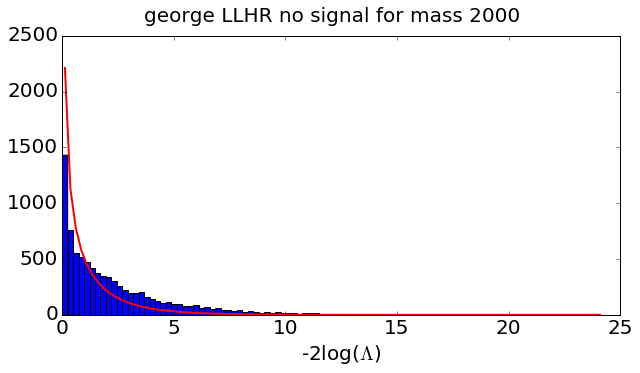

nc  [ 24.28314787]


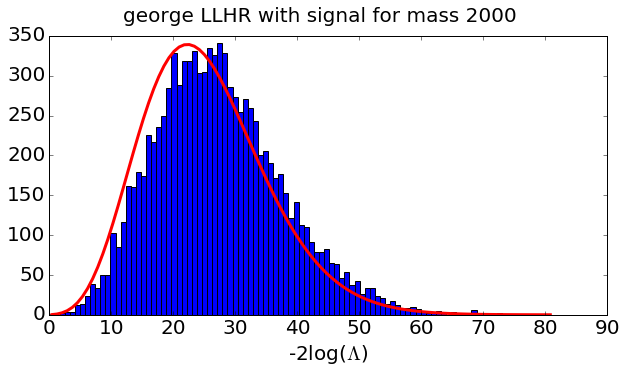

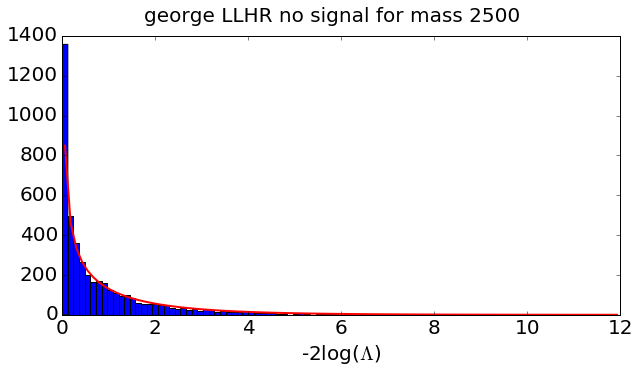

nc  [ 15.61921498]


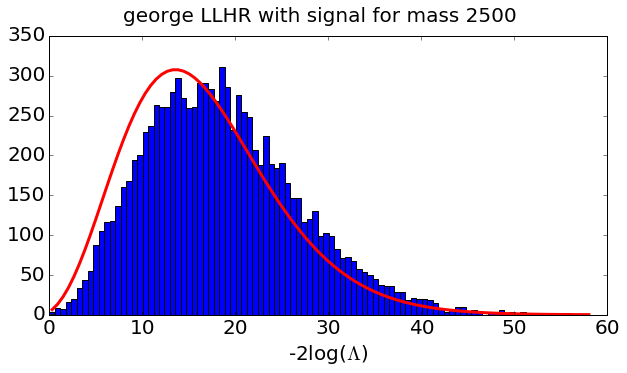

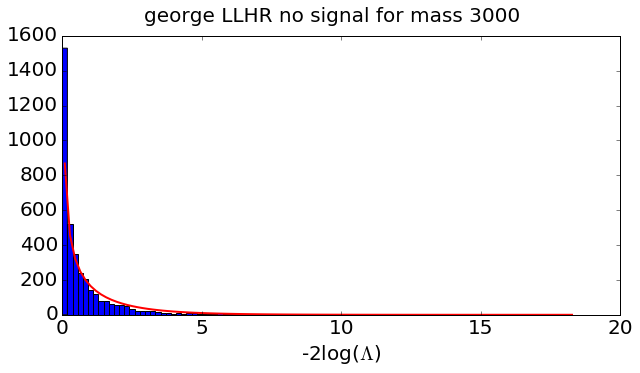

nc  [ 25.18597867]


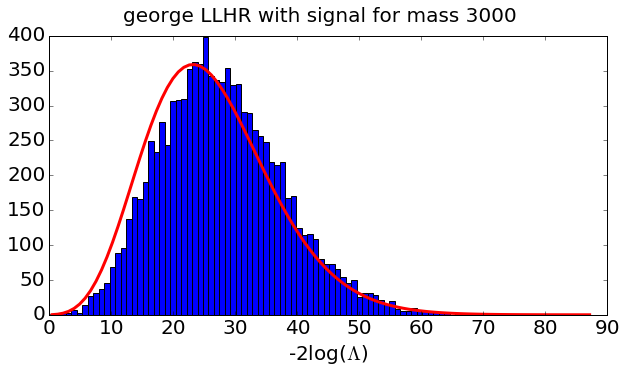

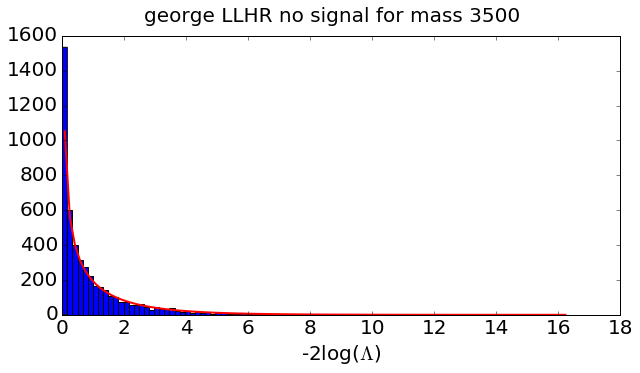

nc  [ 13.57453111]


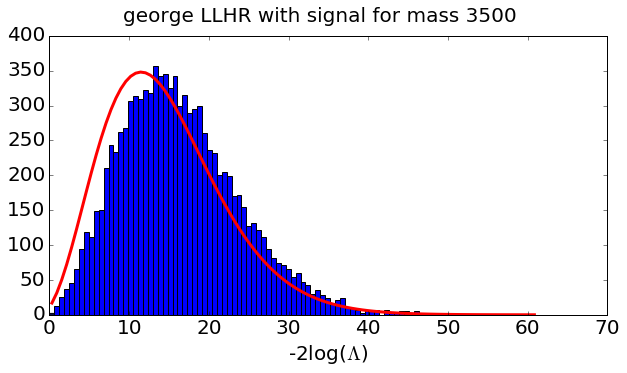

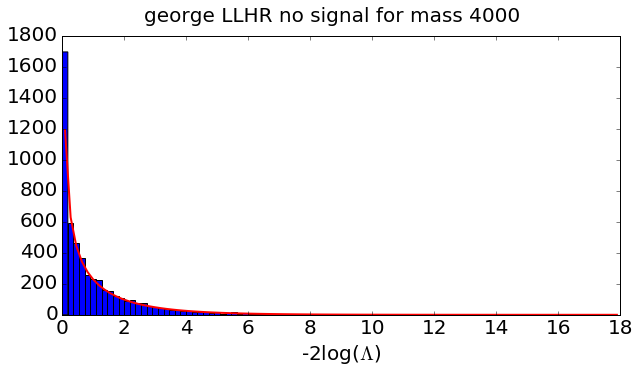

nc  [ 10.37340757]


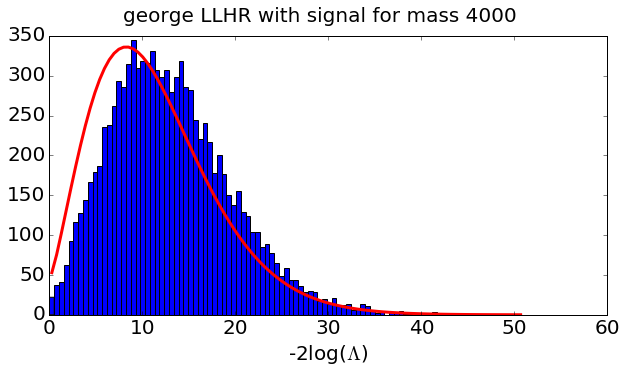

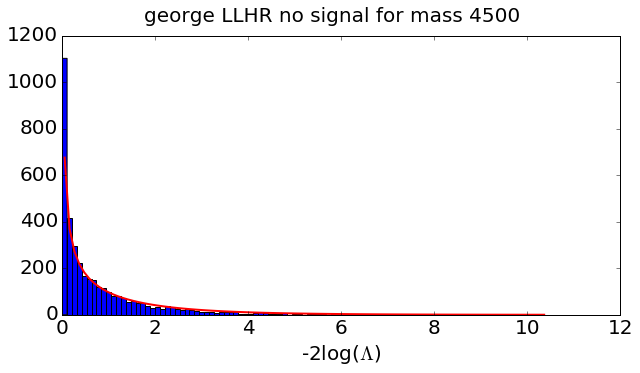

nc  [ 13.09363593]


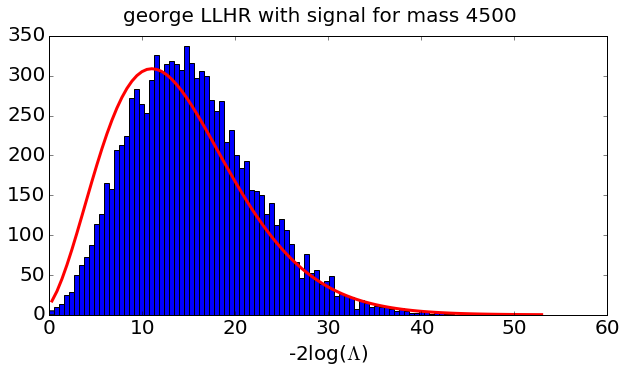

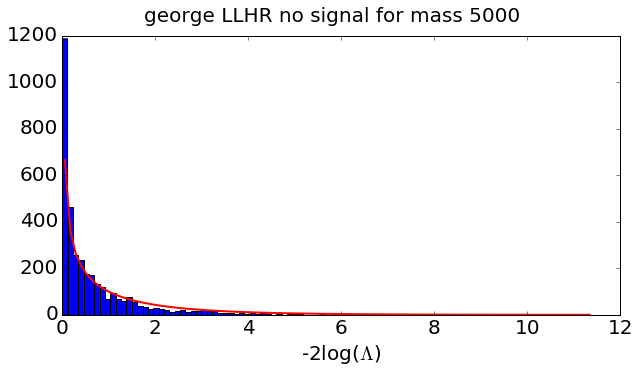

nc  [ 13.05940256]


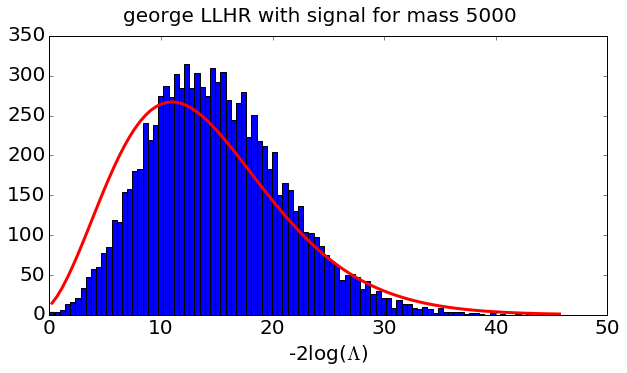

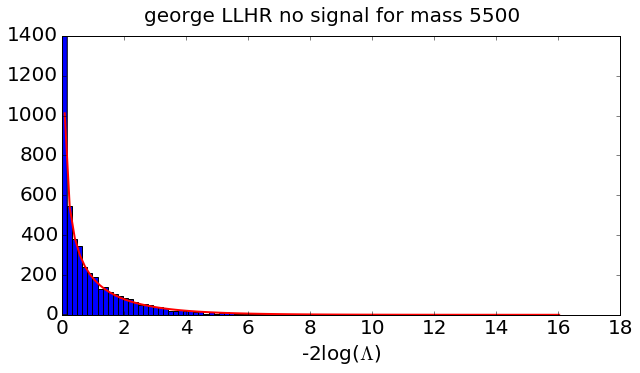

nc  [ 11.86730635]


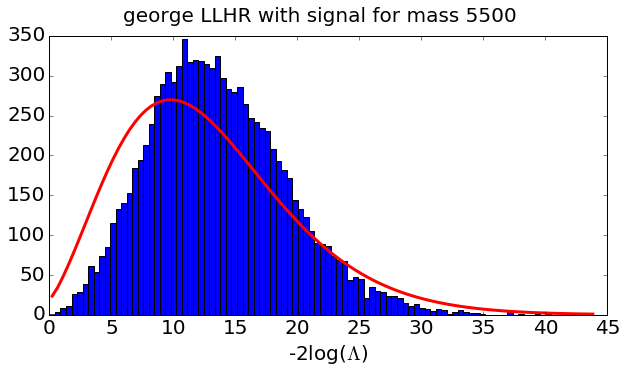

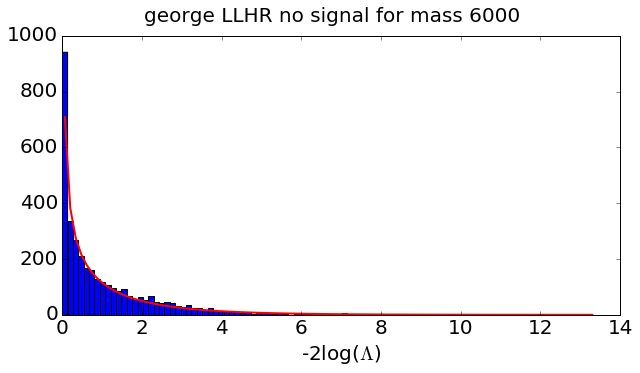

nc  [ 14.57470522]


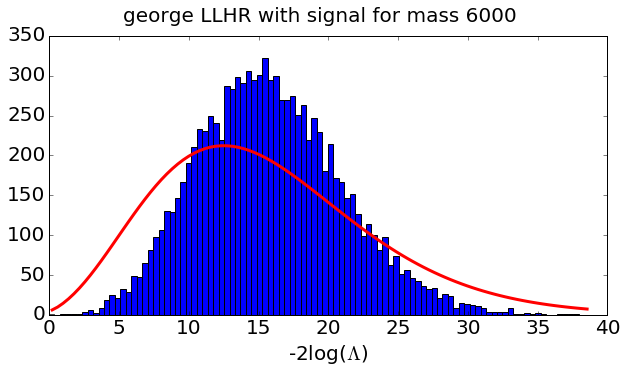

In [70]:
GP_meanLLHR_noSignal=[]
GP_meanLLHR_withSignal=[]
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
for m in msignals:
    gp_LLH_noSignal = [ll for ll in LLHR_GP_noSignal[m] if not (np.isinf(ll) or np.isnan(ll))]
    gp_LLH_withSignal = [ll for ll in LLHR_GP_withSignal[m] if not (np.isinf(ll) or np.isnan(ll))]
    
    
    GP_meanLLHR_noSignal.append([np.median(np.array(gp_LLH_noSignal)), np.std(np.array(gp_LLH_noSignal))])
    GP_meanLLHR_withSignal.append([np.median(np.array(gp_LLH_withSignal)), np.std(np.array(gp_LLH_withSignal))])

    label = "george LLHR no signal for mass "+str(int(m))
    makePrettyPlots_LLH(gp_LLH_noSignal, label, drawchi2=True, drawNCchi2=False, xname = r"-2log($\Lambda$)")

    label = "george LLHR with signal for mass "+str(int(m))
    makePrettyPlots_LLH(gp_LLH_withSignal, label, drawchi2=False, drawNCchi2=True, xname = r"-2log($\Lambda$)")

